In [28]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import xarray as xr

In [ ]:
#Replace with file path for this directory on your machine
!pip install -e /Users/justinmaynard/Documents/GitHub/assetraMP/ 

Obtaining file:///Users/justinmaynard/Documents/GitHub/assetraMP
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for assetra (pyproject.toml) ... done
  Created wheel for assetra: filename=assetra-1.0.3-py3-none-any.whl size=2689 sha256=dbec1acd386afa31ce06d71424f177f8781dc8432d27f26b9e6f1bc595d1c07a
  Stored in directory: /private/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/pip-ephem-wheel-cache-iak9sr6z/wheels/c0/f5/c9/3b09bf7f2c6beadc5d6cde6ca7e50094804a4b90493c211e80
Successfully built assetra
  Attempting uninstall: assetra
    Found existing installation: assetra 1.0.3
    Uninstalling assetra-1.0.3:
      Successfully uninstalled assetra-1.0.3


In [3]:
p = Path(".")
root_folder = p.cwd().parent
root_folder
data_folder = root_folder / 'pjm_2023_test' / 'pjm_data'
data_folder
scripts_foler = root_folder/ 'pjm_2023_test'

### Demand Data

In [5]:
#relative, should work for all
demand_path = str(data_folder/"hrl_load_metered.csv")

def sum_by_datetime(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)
    # Ensure datetime column is parsed correctly
    data['datetime_beginning_ept'] = pd.to_datetime(data['datetime_beginning_ept'])
    # Group by 'datetime_beginning_ept' and sum 'mw'
    grouped_data = data.groupby('datetime_beginning_ept', as_index=False)['mw'].sum()
    grouped_data.index = pd.to_datetime(grouped_data['datetime_beginning_ept'])
    grouped_data = grouped_data.drop(columns='datetime_beginning_ept')

    return grouped_data

# Apply the function to the uploaded file

summed_data = sum_by_datetime(demand_path)


/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_74721/3196234918.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['datetime_beginning_ept'] = pd.to_datetime(data['datetime_beginning_ept'])


In [6]:
summed_data

,mw
datetime_beginning_ept,
2023-01-01 00:00:00,146546.274
2023-01-01 01:00:00,142981.658
2023-01-01 02:00:00,140047.470
2023-01-01 03:00:00,138552.566
2023-01-01 04:00:00,138456.840
...,...
2024-01-01 19:00:00,194766.828
2024-01-01 20:00:00,191178.494
2024-01-01 21:00:00,187060.136


In [7]:
summed_data.to_csv(str(data_folder/"pjm_load_cleaned.csv"))

In [29]:
root_folder

PosixPath('/Users/justinmaynard/Documents/GitHub/assetraMP/examples')

In [30]:
import pandas as pd

# Load PJM data
pjm_file = str(data_folder/'pjm_load_cleaned.csv')
pjm_df = pd.read_csv(pjm_file, parse_dates=['datetime_beginning_ept'])
pjm_datetimes = pjm_df['datetime_beginning_ept']

# Load CISO data
ciso_file = str(root_folder/"01_california/ciso_data/CISO.csv") 
ciso_df = pd.read_csv(ciso_file, parse_dates=['date_time'])
ciso_datetimes = ciso_df['date_time']

# Filter for a single year (e.g., 2023)
pjm_datetimes_2023 = pjm_datetimes[pjm_datetimes.dt.year == 2023]
ciso_datetimes_2023 = ciso_datetimes[ciso_datetimes.dt.year == 2019]

# Compare the datetime values
pjm_set = set(pjm_datetimes_2023)
ciso_set = set(ciso_datetimes_2023)

common_datetimes = pjm_set.intersection(ciso_set)
pjm_only_datetimes = pjm_set - ciso_set
ciso_only_datetimes = ciso_set - pjm_set

print(f"Common datetime values: {len(common_datetimes)}")
print(f"PJM-only datetime values: {len(pjm_only_datetimes)}")
print(f"CISO-only datetime values: {len(ciso_only_datetimes)}")

Common datetime values: 0
PJM-only datetime values: 8759
CISO-only datetime values: 8760


In [ ]:

# Load PJM data
pjm_file = str(data_folder/'pjm_load_cleaned.csv')
pjm_df = pd.read_csv(pjm_file, parse_dates=['datetime_beginning_ept'])

# Generate a complete range of hourly datetime values for the year 2023
full_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')

# Find missing datetime values
pjm_datetimes = pd.to_datetime(pjm_df['datetime_beginning_ept'])
missing_datetimes = full_range.difference(pjm_datetimes)
missing_datetimes

/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_74721/42725211.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:00:00', freq='H')


DatetimeIndex(['2023-03-12 02:00:00'], dtype='datetime64[ns]', freq='h')

In [4]:
#Function to load demand data
def load_pjm_cleaned_hourly_demand(
        pjm_demand_file: Path,
        start_hour: datetime,
        end_hour: datetime) -> xr.DataArray:
    """Return hourly demand data as formatted data array.
    To use this function, download cleaned demand data from:

    https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data

    Args:
        eia_930_cleaned_demand_file (Path): Path to hourly demand file
        start_hour (datetime): First timestamp to include
        end_hour (datetime): Last timestamp to include (inclusive)

    Returns:
        xr.DataArray: Hourly demand array with time dimension and datetime coordinates.
    """
    # read demand file
    pjm_demand_df = pd.read_csv(
        pjm_demand_file,
        usecols=["datetime_beginning_ept", "mw"],
        index_col="datetime_beginning_ept",
        parse_dates=True,
    )

    # keep cleaned demand demand
    pjm_hourly_demand_pd = pjm_demand_df["mw"].loc[start_hour:end_hour]

    # convert to xr.DataArray
    pjm_hourly_demand = xr.DataArray(
        data=pjm_hourly_demand_pd.values,
        coords=dict(
            time=pjm_hourly_demand_pd.index.values
        )
    )
    return pjm_hourly_demand

In [10]:
#Load demand data
pjm_cleaned_demand_file = Path( data_folder / "pjm_load_cleaned.csv")
hourly_demand = load_pjm_cleaned_hourly_demand(
	pjm_cleaned_demand_file,
	start_hour="2023-01-01 00:00:00",
	end_hour="2023-12-31 23:00:00"
)


In [31]:
from assetra.system import EnergySystem
from assetra.system import EnergySystemBuilder

builder = EnergySystemBuilder()
unit_count = 0

In [12]:
# create demand unit
from assetra.units import DemandUnit

builder.add_unit(
    DemandUnit(
        id=unit_count,
        hourly_demand=hourly_demand
    )
)
unit_count += 1

### EIA 860 Data

In [13]:
def load_eia_860_plants(eia_860_plant_file: Path, bal_auth: str) -> pd.DataFrame:
    """Return a subset of the EIA 860 plant file for plants in a balancing authority

    Args:
        eia_860_plant_file (Path): Path to hourly demand file
        bal_auth (str): Balancing authority code as defined by EIA-860

    Returns:
        pd.DataFrame: Plant code-indexed dataframe with plant latitude and longitude
    """
    # read file
    eia_860_plant_df = pd.read_excel(
        eia_860_plant_file,
        skiprows=1,
        usecols=[
            "Plant Code",
            "Latitude",
            "Longitude",
            "Balancing Authority Code",
        ],
        index_col="Plant Code",
    )

    # filter
    eia_860_plant_df = eia_860_plant_df[
        eia_860_plant_df["Balancing Authority Code"] == bal_auth
    ]
    return eia_860_plant_df

In [14]:
# parse eia 860 plants (selecting by balancing authority)
eia_860_plant_file = Path( data_folder / "2___Plant_Y2023.xlsx")
eia_860_plants = load_eia_860_plants(eia_860_plant_file, "PJM")

In [15]:
def load_eia_860_generators(
    eia_860_generator_file: Path,
    eia_860_plants: pd.DataFrame,
    additional_cols: list=[],
    tech_filter: list=[],
    invert_tech_filter: bool=False
    ) -> pd.DataFrame:
    """Return dataframe with generators" latitude, longitude, technology, and nameplate capacity"""
    # read file
    eia_860_generator_df = pd.read_excel(
        eia_860_generator_file,
        skiprows=1,
        usecols=[
            "Plant Code",
            "Technology",
            "Nameplate Capacity (MW)",
            "Status"
        ] + additional_cols,
    )

    # filter by plants
    eia_860_generator_df = eia_860_generator_df[
        eia_860_generator_df["Plant Code"].isin(eia_860_plants.index)
    ]

    # filter by technology
    if tech_filter:
        if invert_tech_filter:
            eia_860_generator_df = eia_860_generator_df[
                ~eia_860_generator_df["Technology"].isin(
                    tech_filter
                )
            ]
        else:
            eia_860_generator_df = eia_860_generator_df[
                eia_860_generator_df["Technology"].isin(
                    tech_filter
                )
            ]

    # filter by status
    eia_860_generator_df = eia_860_generator_df[
        eia_860_generator_df["Status"] == "OP"
    ]

    eia_860_generator_df["Latitude"] = eia_860_generator_df["Plant Code"].map(lambda plant_code: eia_860_plants["Latitude"][plant_code])
    eia_860_generator_df["Longitude"] = eia_860_generator_df["Plant Code"].map(lambda plant_code: eia_860_plants["Longitude"][plant_code])

    return eia_860_generator_df

In [16]:
# parse eia 860 generator types
EIA_860_NON_THERMAL_TECHNOLOGY = [
    "Onshore Wind Turbine",
    #"Conventional Hydroelectric",
    "Solar Photovoltaic",
    "Offshore Wind Turbine",
    "Batteries",
    "Hydroelectric Pumped Storage"
]
eia_860_generator_file = Path(data_folder / "3_1_Generator_Y2023.xlsx")
eia_860_wind_file = Path(data_folder / "3_2_Wind_Y2023.xlsx")
eia_860_solar_file = Path(data_folder / "3_3_Solar_Y2023.xlsx")
eia_860_storage_file = Path(data_folder / "3_4_Energy_Storage_Y2023.xlsx")

eia_860_thermal_generators = load_eia_860_generators(
    eia_860_generator_file, 
    eia_860_plants,
    tech_filter=EIA_860_NON_THERMAL_TECHNOLOGY,
    invert_tech_filter=True
)
eia_860_wind_generators = load_eia_860_generators(
    eia_860_wind_file,
    eia_860_plants
)
eia_860_solar_generators = load_eia_860_generators(
    eia_860_solar_file,
    eia_860_plants
)
eia_860_storage_generators = load_eia_860_generators(
    eia_860_storage_file,
    eia_860_plants,
    additional_cols=["Nameplate Energy Capacity (MWh)"]
)

### Import MERRA

In [17]:
import xarray as xr

# load processed power generation dataset (solar cf, wind cf, and temperature)
pow_gen_file = Path(data_folder / "pjm_power_generation_2023.nc")
pow_gen_dataset = xr.open_dataset(pow_gen_file)

def get_nearest_hourly_profile(
    latitude: float,
    longitude: float,
    array: xr.DataArray
) -> xr.DataArray:
    """Return time series corresponding to the nearest coordinate in a
    MERRA power generation data array.

    Args:
        latitude (float): Latitude relative to equator in degrees
        start_hour (datetime): Longitude relative to meridian in degrees
        array (xr.DataArray): "solar_capacity_factor", "wind_capacity_factor",
            or "temperature"

    Returns:
        xr.DataArray: Array with time dimension and datetime coordinates.
    """
    return array.sel(
            lat=latitude, 
            lon=longitude, 
            method="nearest"
        ).squeeze(drop=True)

def get_merra_power_generation_solar_cf(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["solar_capacity_factor"])

def get_merra_power_generation_wind_cf(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["wind_capacity_factor"])

def get_merra_power_generation_temperature(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["temperature"])

In [18]:
import pandas as pd

# load temperature dependent outage rate (tdfor) table
tdfor_table_file = Path(data_folder / "temperature_dependent_outage_rates.csv")
tdfor_table = pd.read_csv(tdfor_table_file, index_col=0)
tdfor_table = tdfor_table / 100 # percentages stored as integers

# create mapping table for tdfor table
tech_categories = {
    "CC" : ["Natural Gas Fired Combined Cycle"],
    "CT" : ["Natural Gas Fired Combustion Turbine","Landfill Gas"],
    "DS" : ["Natural Gas Internal Combustion Engine"],
    "ST" : ["Conventional Steam Coal","Natural Gas Steam Turbine"],
    "NU" : ["Nuclear"],
    "HD" : ["Conventional Hydroelectric","Solar Thermal without Energy Storage",
                   "Hydroelectric Pumped Storage","Solar Thermal with Energy Storage","Wood/Wood Waste Biomass"]
}

# create mapping from technology to category
tech_mapping = {tech : cat for cat, techs in tech_categories.items() for tech in techs}

def get_hourly_forced_outage_rate(hourly_temperature: xr.DataArray, technology: str) -> xr.DataArray:
    # index tdfor table by tech
    tdfor_map = tdfor_table[tech_mapping.get(technology, "Other")]
    map_temp_to_for = lambda hourly_temperature: tdfor_map.iloc[
            tdfor_map.index.get_indexer(hourly_temperature, method="nearest")
        ]
    return xr.apply_ufunc(
        map_temp_to_for,
        hourly_temperature
    ).rename("hourly_forced_outage_rate")


### Build Units

In [19]:
from assetra.units import StochasticUnit

for _, generator in eia_860_thermal_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["Latitude"],
        generator["Longitude"]
    )

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # get hourly capacity
    hourly_capacity = ( 
        xr.ones_like(hourly_temperature).rename("hourly_capacity") 
        * generator["Nameplate Capacity (MW)"]
    )

    # create assetra energy unit
    thermal_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate
        )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(thermal_unit)

In [20]:


from assetra.units import StochasticUnit

# add solar
for _, generator in eia_860_solar_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["Latitude"],
        generator["Longitude"]
    )
    # get hourly temperature
    hourly_capacity = get_merra_power_generation_solar_cf(
        generator["Latitude"],
        generator["Longitude"]
    ) * generator["Nameplate Capacity (MW)"]

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # create assetra energy unit
    solar_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate
        )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(solar_unit)

# add wind
for _, generator in eia_860_wind_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["Latitude"],
        generator["Longitude"]
    )
    # get hourly temperature
    hourly_capacity = get_merra_power_generation_wind_cf(
        generator["Latitude"],
        generator["Longitude"]
    ) * generator["Nameplate Capacity (MW)"]

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # create assetra energy unit
    wind_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate
        )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(wind_unit)



In [21]:
from assetra.units import StorageUnit

STORAGE_EFFICIENCY = 0.8

for _, generator in eia_860_storage_generators.iterrows():
    storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"]
    if storage_duration < 4:
        storage_class = '<4 hour'
    elif 4 <= storage_duration < 6:
        storage_class = '4-6 hour'
    elif 6 <= storage_duration < 8:
        storage_class = '6-8 hour'
    elif 8 <= storage_duration < 10:
        storage_class = '8-10 hour'
    else:
        storage_class = '10+ hour'

    storage_unit = StorageUnit(
        id=unit_count,
        nameplate_capacity=generator["Nameplate Capacity (MW)"],
        charge_rate=generator["Nameplate Capacity (MW)"],
        discharge_rate=generator["Nameplate Capacity (MW)"],
        charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
        roundtrip_efficiency = STORAGE_EFFICIENCY,
        storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"],
        storage_class = storage_class       

        
    )
    unit_count += 1

    # add unit to energy system
    builder.add_unit(storage_unit)

In [23]:

pjm_system_dir = Path(data_folder / "pjm_energy_system")

if pjm_system_dir.exists():
    energy_system = EnergySystem()
    energy_system.load(pjm_system_dir)
else:
    print("PJM saved system not found. Please create and save this system following the instructions found in the appendix") 

PJM saved system not found. Please create and save this system following the instructions found in the appendix


In [24]:
energy_system = builder.build()
energy_system.save(pjm_system_dir)

In [25]:
if pjm_system_dir.exists():
    energy_system = EnergySystem()
    energy_system.load(pjm_system_dir)
else:
    print("PJM saved system not found. Please create and save this system following the instructions found in the appendix") 

In [26]:
print("# of Units:", energy_system.size)
print("Sys. Capacity (MW):", round(energy_system.system_capacity))

# of Units: 3466
Sys. Capacity (MW): 212271


In [27]:
storageUnit = xr.open_dataset(data_folder/ "pjm_energy_system/StorageUnit.assetra.nc")
sotrage_dataframe = storageUnit.to_dataframe() #.to_csv("demandunit.csv")
sotrage_dataframe


,nameplate_capacity,charge_rate,discharge_rate,charge_capacity,roundtrip_efficiency,storage_duration,storage_class
energy_unit,,,,,,,
3434,2.0,2.0,2.0,1.0,0.8,0.500000,<4 hour
3435,2.0,2.0,2.0,0.8,0.8,0.400000,<4 hour
3436,1.0,1.0,1.0,1.0,0.8,1.000000,<4 hour
3437,10.4,10.4,10.4,10.4,0.8,1.000000,<4 hour
3438,20.0,20.0,20.0,8.3,0.8,0.415000,<4 hour
3439,16.0,16.0,16.0,16.0,0.8,1.000000,<4 hour
3440,20.0,20.0,20.0,15.0,0.8,0.750000,<4 hour
3441,0.8,0.8,0.8,3.4,0.8,4.250000,4-6 hour
3442,11.0,11.0,11.0,5.0,0.8,0.454545,<4 hour


In [32]:
from assetra.simulation import ProbabilisticSimulation

simulation = ProbabilisticSimulation(
    start_hour="2023-01-01 00:00:00",
    end_hour="2023-12-31 23:00:00",
    trial_size=1
)

simulation.assign_energy_system(energy_system)
simulation.run()

Energy system unit datasets: {<class 'assetra.units.DemandUnit'>: <xarray.Dataset> Size: 140kB
Dimensions:             (energy_unit: 1, time: 8759)
Coordinates:
  * time                (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T...
  * energy_unit         (energy_unit) int64 8B 0
Data variables:
    nameplate_capacity  (energy_unit) int64 8B 0
    hourly_capacity     (energy_unit, time) float64 70kB ..., <class 'assetra.units.StochasticUnit'>: <xarray.Dataset> Size: 481MB
Dimensions:                    (energy_unit: 3433, time: 8760)
Coordinates:
    lat                        float64 8B ...
    lon                        float64 8B ...
  * time                       (time) datetime64[ns] 70kB 2023-01-01 ... 2023...
  * energy_unit                (energy_unit) int64 27kB 1 2 3 ... 3431 3432 3433
Data variables:
    nameplate_capacity         (energy_unit) float64 27kB 149.0 98.0 ... 108.3
    hourly_capacity            (energy_unit, time) float64 241MB ...
    hourly_forced_o

KeyError: "not all values found in index 'time'"

The ProbabilisticSimulation object generates a net hourly capacity matrix, representing net system capacity in each Monte Carlo trial. We can access a copy of this matrix to analyze shortfalls.

In [121]:
# convert net hourly capacity matrix to pandas dataframe with risk hours only
shortfall_matrix_pd = simulation.net_hourly_capacity_matrix.where(lambda c: c < 0).to_pandas().T.dropna(how="all")
shortfall_matrix_pd

trial,0
time,
2023-01-04 17:00:00,-1769.558262
2023-01-06 07:00:00,-2922.911940
2023-01-06 08:00:00,-8985.210138
2023-01-06 09:00:00,-10051.662559
2023-01-06 10:00:00,-9962.505153
...,...
2023-12-29 17:00:00,-5455.742970
2023-12-29 18:00:00,-1543.025477
2023-12-29 19:00:00,-4157.416729



We can calculate hourly loss of load probability from the net hourly capacity matrix

In [124]:
# get loss of load probability
loss_of_load_prob = shortfall_matrix_pd.count(axis=1) / shortfall_matrix_pd.shape[1]

# show top 10 risk hours
loss_of_load_prob.sort_values(ascending=False)[:10]

time
2023-01-04 17:00:00    1.0
2023-08-18 18:00:00    1.0
2023-08-17 16:00:00    1.0
2023-08-17 17:00:00    1.0
2023-08-17 18:00:00    1.0
2023-08-17 19:00:00    1.0
2023-08-17 20:00:00    1.0
2023-08-17 21:00:00    1.0
2023-08-17 22:00:00    1.0
2023-08-17 23:00:00    1.0
dtype: float64

In [125]:
# show shortfalls in first 5 trials
shortfall_matrix_pd.loc[:,:5]

trial,0
time,
2023-01-04 17:00:00,-1769.558262
2023-01-06 07:00:00,-2922.911940
2023-01-06 08:00:00,-8985.210138
2023-01-06 09:00:00,-10051.662559
2023-01-06 10:00:00,-9962.505153
...,...
2023-12-29 17:00:00,-5455.742970
2023-12-29 18:00:00,-1543.025477
2023-12-29 19:00:00,-4157.416729


In [126]:
!pip install matplotlib

In [191]:
from assetra.metrics import ExpectedUnservedEnergy

# instantiate eue model
eue_model = ExpectedUnservedEnergy(simulation)
eue = eue_model.evaluate()

print("System EUE:", round(eue, 2), "MWh")

System EUE: 67383436.78 MWh


In [192]:
from assetra.metrics import LossOfLoadHours, LossOfLoadDays, LossOfLoadFrequency
import pandas as pd

adequacy = pd.Series(dtype=float)

for name, metric in [
    ("EUE (MWh)", ExpectedUnservedEnergy),
    ("LOLH (h)", LossOfLoadHours),
    ("LOLD (d)", LossOfLoadDays),
    ("LOLF (#)", LossOfLoadFrequency)
]:
    adequacy[name] = metric(simulation).evaluate()

# show results
adequacy.round(1)

EUE (MWh)    67383436.8
LOLH (h)         2610.0
LOLD (d)          226.0
LOLF (#)          279.0
dtype: float64

In [132]:
adequacy["Average Outage Duration (h)"] = adequacy["LOLH (h)"] / adequacy["LOLF (#)"]
adequacy["Average Shortfall (MW)"] = adequacy["EUE (MWh)"] / adequacy["LOLH (h)"]

# show results
adequacy.round(1)


EUE (MWh)                      67383436.8
LOLH (h)                           2610.0
LOLD (d)                            226.0
LOLF (#)                            279.0
Average Outage Duration (h)           9.4
Average Shortfall (MW)            25817.4
dtype: float64

Quantify resource contribution (ELCC)

Resource contribution is a typical extension of resource adequacy analysis. The assetra package implements effective load-carrying capability (ELCC) to quantify resource contribution. When we instantiate an EffectiveLoadCarryingCapability object, the base system will automatically be evaluated according to the ResourceAdequacyMetric type we provide. In the following example, we indicate that resource adequacy should be defined as EUE (e.g. rather than LOLH) by passing ExpectedUnservedEnergy (the class not an instance) as the last parameter to the ELCC instance.


In [134]:
from assetra.contribution import EffectiveLoadCarryingCapability
from assetra.simulation import ProbabilisticSimulation
from assetra.metrics import ExpectedUnservedEnergy

# initialize elcc model
elcc_model = EffectiveLoadCarryingCapability(
    energy_system,
    ProbabilisticSimulation(
        start_hour="2023-01-01 00:00:00",
        end_hour="2023-12-31 23:00:00",
        trial_size=100
    ),
    ExpectedUnservedEnergy
)


INFO:assetra.units:Using chunk size 115
INFO:assetra.units:Sampling outages for units 1-115 of 3433
INFO:assetra.units:Sampling outages for units 116-230 of 3433
INFO:assetra.units:Sampling outages for units 231-345 of 3433
INFO:assetra.units:Sampling outages for units 346-460 of 3433
INFO:assetra.units:Sampling outages for units 461-575 of 3433
INFO:assetra.units:Sampling outages for units 576-690 of 3433
INFO:assetra.units:Sampling outages for units 691-805 of 3433
INFO:assetra.units:Sampling outages for units 806-920 of 3433
INFO:assetra.units:Sampling outages for units 921-1035 of 3433
INFO:assetra.units:Sampling outages for units 1036-1150 of 3433
INFO:assetra.units:Sampling outages for units 1151-1265 of 3433
INFO:assetra.units:Sampling outages for units 1266-1380 of 3433
INFO:assetra.units:Sampling outages for units 1381-1495 of 3433
INFO:assetra.units:Sampling outages for units 1496-1610 of 3433
INFO:assetra.units:Sampling outages for units 1611-1725 of 3433
INFO:assetra.units:

In [138]:
storageUnits = xr.open_dataset(data_folder/ "pjm_energy_system/StorageUnit.assetra.nc")
storageUnits.to_dataframe() #.to_csv("demandunit.csv")

,nameplate_capacity,charge_rate,discharge_rate,charge_capacity,roundtrip_efficiency
energy_unit,,,,,
0,2.0,2.0,2.0,1.0,0.8
1,2.0,2.0,2.0,0.8,0.8
2,1.0,1.0,1.0,1.0,0.8
3,10.4,10.4,10.4,10.4,0.8
4,20.0,20.0,20.0,8.3,0.8
...,...,...,...,...,...
3493,12.0,12.0,12.0,12.0,0.8
3494,20.0,20.0,20.0,20.0,0.8
3495,7.0,7.0,7.0,7.0,0.8


In [162]:
eia_860_new_storage_generators = pd.DataFrame(columns = eia_860_storage_generators.columns)
eia_860_new_storage_generators.loc[0] = [9999, 'OP', 'Batteries', 10, 10, "", ""]

In [163]:
eia_860_new_storage_generators

,Plant Code,Status,Technology,Nameplate Capacity (MW),Nameplate Energy Capacity (MWh),Latitude,Longitude
0,9999,OP,Batteries,10,10,,


In [164]:
builder = EnergySystemBuilder()

for _, generator in eia_860_new_storage_generators.iterrows():
    storage_unit = StorageUnit(
        id=unit_count,
        nameplate_capacity=generator["Nameplate Capacity (MW)"],
        charge_rate=generator["Nameplate Capacity (MW)"],
        discharge_rate=generator["Nameplate Capacity (MW)"],
        charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
        roundtrip_efficiency=STORAGE_EFFICIENCY
    )
    unit_count += 1
    builder.add_unit(storage_unit)

    # add unit to energy system
additional_system = builder.build()

In [ ]:
eia_860_new_storage_generators.loc[0]['Nameplate Capacity (MW)']

10

In [166]:
elcc = elcc_model.evaluate(additional_system)
elcc_pct = elcc / eia_860_new_storage_generators.loc[0]['Nameplate Capacity (MW)'] * 100

INFO:assetra.units:Dispatching storage unit 0 of 1 in all hours
INFO:assetra.units:Dispatching storage unit 0 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 1 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 2 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 3 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 4 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 5 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 6 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 7 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 8 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 9 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 10 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 11 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 12 of 64 in all hours
INFO:assetra.units:Dispatching storage unit 13 of 64 in all hours
INFO:assetra.units:Dis

In [33]:
elcc / eia_860_new_storage_generators.loc[0]['Nameplate Capacity (MW)'] * 100

NameError: name 'elcc' is not defined

In [181]:
elcc_model._original_resource_adequacy

67348177.18360406

In [ ]:
elcc_model.evaluate

In [175]:
elcc  * 100

89.84375

In [167]:
# display result
print("ELCC (%): ", round(elcc_pct, 1))



ELCC (%):  9.0


In [184]:
final_added_demand, final_net_hourly_capacity_matrix = [i for i in elcc_model.intermediate_net_capacity_matrices][-1]

In [186]:
import xarray as xr

def get_hourly_risk(net_hourly_capacity_matrix: xr.DataArray) -> xr.DataArray:
    hourly_outage_matrix = -net_hourly_capacity_matrix.where(lambda c: c < 0)
    hourly_risk = hourly_outage_matrix.sum(dim="trial") / hourly_outage_matrix.sizes["trial"]
    return hourly_risk

# get shifted risk
original_risk = get_hourly_risk(elcc_model.original_net_capacity_matrix)
final_risk = get_hourly_risk(final_net_hourly_capacity_matrix)
shifted_risk = (final_risk - original_risk).where(lambda c: c != 0)

# convert to pandas
shifted_risk_pd = shifted_risk.to_pandas().dropna(how="all")

# display
shifted_risk_pd


time
2023-01-03 17:00:00   -0.160917
2023-01-03 18:00:00   -0.706156
2023-01-04 19:00:00   -0.080458
2023-01-05 07:00:00   -0.563208
2023-01-05 08:00:00   -1.761099
                         ...   
2023-12-30 22:00:00   -0.080458
2023-12-31 17:00:00   -0.321833
2023-12-31 18:00:00   -0.938547
2023-12-31 19:00:00   -0.241375
2023-12-31 20:00:00   -0.312391
Length: 3254, dtype: float64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/ipykernel_39293/119856820.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(shifted_risk_pd.index.strftime('%m-%d %H:%M'))


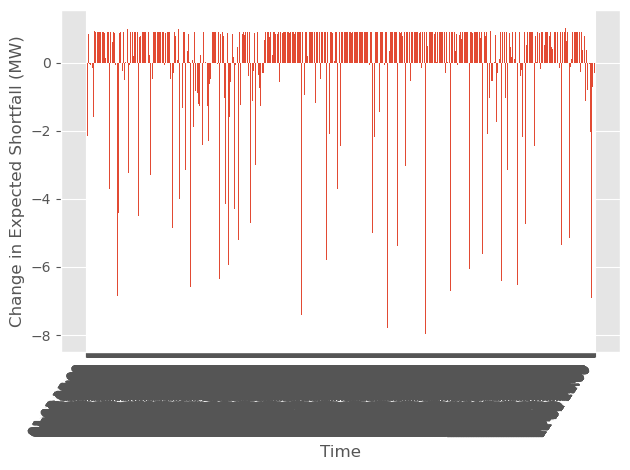

In [187]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots()

ax.bar(shifted_risk_pd.index.astype(str), shifted_risk_pd)

ax.set_xlabel("Time")
ax.set_ylabel("Change in Expected Shortfall (MW)")
ax.set_xticklabels(shifted_risk_pd.index.strftime('%m-%d %H:%M'))
plt.xticks(rotation=55, ha='right')
plt.tight_layout()

plt.show()